(time-frequency-analysis)=
# Time-Frequency Analysis

In this section we will discuss the representation of signals in time and frequency domain and how it can be useful for analysis.

## Fourier Series Expansion

Let's revisit the sine wave example. It can be represented by its amplitude, frequency, and phase. 


A periodic signal can be decomposed into a sum of sine waves with different amplitudes, frequencies, and phases. For example, below is a decomposition of a square wave.

$$\textrm{square wave} = sin(x) + sin(3x)/3 + sin(5x)/5 + sin(7x)/7 ...$$

![](https://upload.wikimedia.org/wikipedia/commons/b/bd/Sigma-approximation_of_a_Square_Wave_.gif)



Image Source: Wikipedia

The representation can be obtained by calculating the [**Fourier Series**](https://mathworld.wolfram.com/FourierSeries.html) for the function. 

## Fourier Transform

The analogue for this representation for discrete signals can be obtained through the **Discrete Fourier Transform**.


$$ \mathcal{\hat{f}}[k] = \sum_{n=0}^{N-1}e^{-2\pi j \frac{kn}{N}}f[n] $$

This converts the signal from the time domain to frequency domain.

:::{note}
We can interpret it as a matched filter against waves with different frequencies.
:::

### Sine Wave Frequency Representation Example

In [1]:
import numpy as np
import scipy as sp
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

In [2]:
# Sine Wave
freq = 100
N = 1000
end_time = 1
time = np.linspace(0, end_time, end_time*N, endpoint=False) # 1 sec
A = 1
cw = A*np.sin(2*np.pi*freq*time)

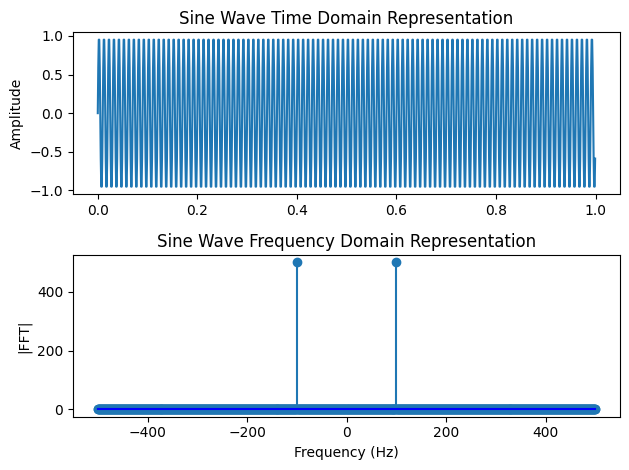

In [3]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, cw)
ax1.title.set_text("Sine Wave Time Domain Representation")
ax1.set_ylabel("Amplitude")
fig.tight_layout()

ax2.stem(fftfreq(N, 1)*N, np.abs(fft(cw)), basefmt='b-')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|FFT|")
ax2.title.set_text("Sine Wave Frequency Domain Representation")
fig.tight_layout()

:::{note}
The FFT is symmetric and the maximum positive frequency is half the sampling frequency (within which we can accurately reconstruct the signal thanks to the [Nyquist-Shannon Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)). We can limit to display only one side of the plot.
:::

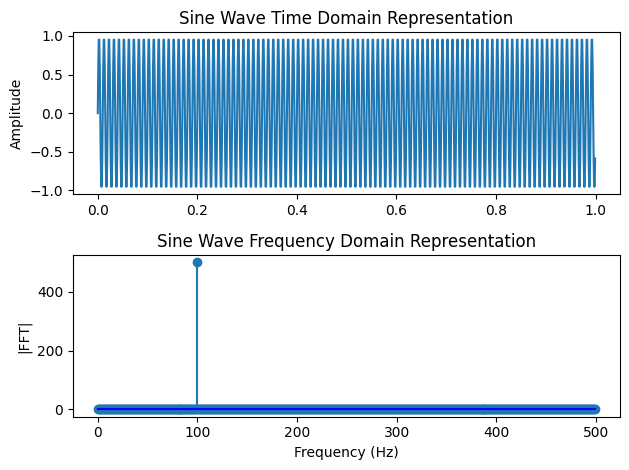

In [4]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, cw)
ax1.title.set_text("Sine Wave Time Domain Representation")
ax1.set_ylabel("Amplitude")
fig.tight_layout()

ax2.stem(N*fftfreq(N, 1)[:np.round(N//2)], np.abs(fft(cw))[:(N//2)], basefmt='b-')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|FFT|")
ax2.title.set_text("Sine Wave Frequency Domain Representation")
fig.tight_layout()

:::{note}
We can see that the only npn-zero frequency is 100Hz, the frequency of the sine wave.
:::

### Chirp Frequency Representation Example

In [5]:
# Chirp
chirp = sp.signal.chirp(time, f0=1, t1=1, f1=100)

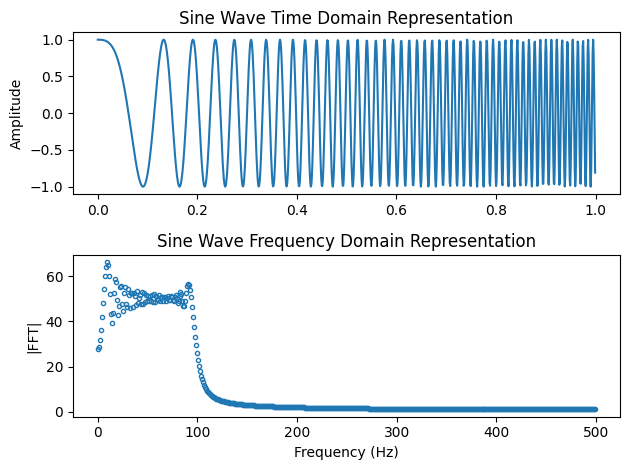

In [6]:
# Chirp FFT

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, chirp)
ax1.title.set_text("Sine Wave Time Domain Representation")
ax1.set_ylabel("Amplitude")
fig.tight_layout()

# ax2.stem(N*fftfreq(N, 1)[:np.round(N//2)], np.abs(fft(chirp))[:(N//2)], basefmt='b-')
ax2.plot(N*fftfreq(N, 1)[:np.round(N//2)], np.abs(fft(chirp))[:(N//2)], '.', markerfacecolor='none')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|FFT|")
ax2.title.set_text("Sine Wave Frequency Domain Representation")
fig.tight_layout()

:::{note}
We can see that the chirp contains frequency information across a range of frequencies (1-100 Hz).
:::

## Short-Time Fourier Transform Representation

The chirp has non-constant frequency which is increasing over time. This is hard to see in the frequency representation because we have lost the time information. To represent both we can split the signal into short intervals and compute the FFT for each of them, and plot the values in time and frequency (**Short-Term Fourier Transform**/**Spectrogram**). The segments can be also overlapping.

### Sine Wave Spectrogram

Text(0, 0.5, 'Frequency (Hz)')

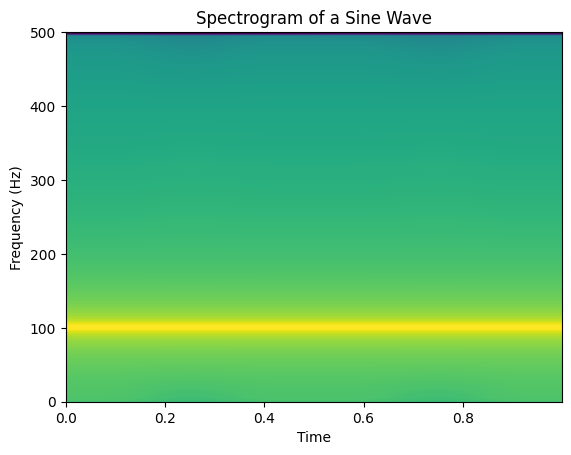

In [7]:
s, s_freq, s_t, im = plt.specgram(cw, NFFT = 256, Fs = N, xextent=[time[0],time[-1]])
plt.title("Spectrogram of a Sine Wave")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")

:::{note}
Since the frequency is constant we observe a horizontal bar at 100Hz.
:::

### Chirp Spectrogram

Text(0, 0.5, 'Frequency (Hz)')

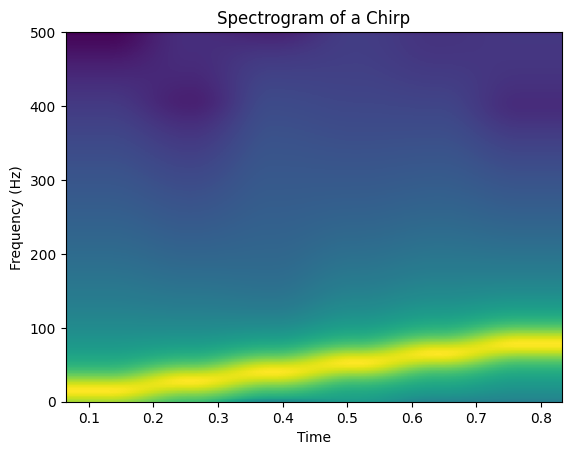

In [8]:
s, s_freq, s_t, im = plt.specgram(chirp, NFFT=256, Fs = N)#, interpolation='none')
plt.title("Spectrogram of a Chirp")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
# plt.xticks(s_t)

:::{note}
We observe the linear increase of frequency over time. The line looks smooth but slightly wiggly. This is a result of the automatic interpolation of the plotting function, which can be turned off to correctly interpret the discrete values.
:::

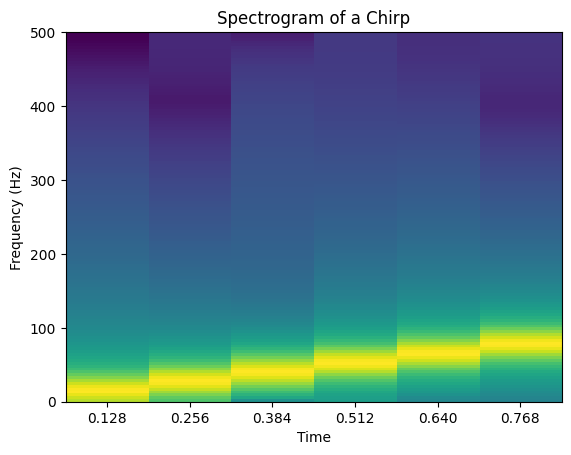

In [9]:
s, s_freq, s_t, im = plt.specgram(chirp, NFFT=256, Fs = N, interpolation='none', mode='magnitude')
plt.title("Spectrogram of a Chirp")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
out = plt.xticks(s_t)

The `plt.specgram` function has a lot of parameters which are hidden under the hood in the above default call. We will explain how they affect the creation of the spectrogram. The key parameters that affect the shape (and the resolution) of the output image are the intervals into which we split the original signal and whether those intervals are overlapping. This determines the number of time and frequency bins of the spectrograms.

![](https://www.mathworks.com/help/signal/ug/siganalyzer_display.png)

It is crucial to read the documentation of the actual spectrogram function since the vocabulary can vary across libraries.

In [10]:
help(plt.specgram)

Help on function specgram in module matplotlib.pyplot:

specgram(x: 'ArrayLike', NFFT: 'int | None' = None, Fs: 'float | None' = None, Fc: 'int | None' = None, detrend: "Literal['none', 'mean', 'linear'] | Callable[[ArrayLike], ArrayLike] | None" = None, window: 'Callable[[ArrayLike], ArrayLike] | ArrayLike | None' = None, noverlap: 'int | None' = None, cmap: 'str | Colormap | None' = None, xextent: 'tuple[float, float] | None' = None, pad_to: 'int | None' = None, sides: "Literal['default', 'onesided', 'twosided'] | None" = None, scale_by_freq: 'bool | None' = None, mode: "Literal['default', 'psd', 'magnitude', 'angle', 'phase'] | None" = None, scale: "Literal['default', 'linear', 'dB'] | None" = None, vmin: 'float | None' = None, vmax: 'float | None' = None, *, data=None, **kwargs) -> 'tuple[np.ndarray, np.ndarray, np.ndarray, AxesImage]'
    Plot a spectrogram.

    Compute and plot a spectrogram of data in *x*.  Data are split into
    *NFFT* length segments and the spectrum of each

* `NFFT` is the number of points in each segment. By default it is set to 256.
* `noverlap` is the number of points of overlap. By default it is set to 128.

We note that center of the bin corresponds to the center of the segment from which the data came from and the difference of two consecutive bins is 128/1000 which corresponds to (`NFFT` - `noverlap`)/`N`.

### Spectrogram Widget

We will demonstrate how the spectrogram is created through a widget.

In [11]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [12]:
def plot_stft_slice(t, NFFT=256, noverlap=128):

    fig, ax = plt.subplots(2,2)
    fig.set_figheight(6)
    fig.set_figwidth(10)


    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()

    # identify time window based on t and NFFT
    win_length = NFFT/N

    # plot raw signal with window
    ax[0,0].plot(time, chirp)

    # plot spectrogram with a verical line
    s, s_freq, s_t, im = ax[1,0].specgram(chirp, NFFT=NFFT, noverlap=noverlap, Fs = N, interpolation='none')
    ax[0,0].axvline(t-win_length/2, color="r")
    ax[0,0].axvline(t+win_length/2, color="r")
    ax[0,0].axvspan(t-win_length/2, t+win_length/2, color='red', alpha=.5)
    ax[0,0].set_ylim((-1.1,1.1))
    ax[0,0].set_xlim((0,1))
    ax[0,0].set_title("Chirp")


    idx = np.where(s_t == t)[0]
    ax[1,0].axvline(t, color='r')
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Frequency")
    ax[1,0].set_title("STFT")
    ax[1,0].set_xticks(np.concat(([0],s_t, [1])))
    print(s_t)


    # plot power spectrum of slice
    ax[1,1].plot(s[:,idx], s_freq)
    ax[1,1].set_xlabel("|FFT|")
    ax[1,1].set_title("|FFT|")
    ax[1,1].set_xlim((-0.001, 0.1))

    # making one axis invisible
    ax[0,1].axis('off')
    plt.show()

In [13]:
NFFT_widget = widgets.SelectionSlider(options=[256, 512, 1024])
NFFT_widget.value = 256
noverlap_widget = widgets.SelectionSlider(options=[0,32,64,128])
noverlap_widget.value = 128

time_widget = widgets.SelectionSlider(options=np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N)


# Update function
def update_time_slider(change):
    time_widget.options = np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N

NFFT_widget.observe(update_time_slider, names='value')
noverlap_widget.observe(update_time_slider, names='value')


out = interactive(plot_stft_slice, NFFT=NFFT_widget, noverlap=noverlap_widget, t=time_widget)
display(out)

interactive(children=(SelectionSlider(description='t', options=(np.float64(0.128), np.float64(0.256), np.float…

### Impulse Spectrogram

/home/codespace/.local/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


([<matplotlib.axis.XTick at 0x778556685880>,
 [Text(0.128, 0, '0.128'),
  Text(0.256, 0, '0.256'),
  Text(0.384, 0, '0.384'),
  Text(0.512, 0, '0.512'),
  Text(0.64, 0, '0.640'),
  Text(0.768, 0, '0.768')])

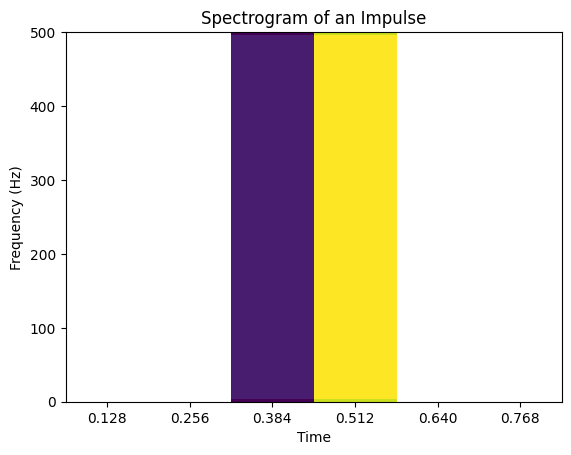

In [14]:
impulse = sp.signal.unit_impulse(len(time), round(len(time)/2))
s, s_freq, s_t, im = plt.specgram(impulse, NFFT=256, Fs = N, interpolation='none')# , scale='linear', mode='magnitude') 
plt.title("Spectrogram of an Impulse")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.xticks(s_t)

:::{caution}
What is going on? By default `plt.specgram` plots in dB scale. When the value is zero the resulting plot contains NaNs. To plot on a linear scale one needs to set `scale='linear'`, and also check the method used: by default it is `mode='psd'` a statistical estimate of the spectrum, while `mode='magnitude'` corresponds to the magnitude of the FFT.
:::

([<matplotlib.axis.XTick at 0x77855664c230>,
 [Text(0.128, 0, '0.128'),
  Text(0.256, 0, '0.256'),
  Text(0.384, 0, '0.384'),
  Text(0.512, 0, '0.512'),
  Text(0.64, 0, '0.640'),
  Text(0.768, 0, '0.768')])

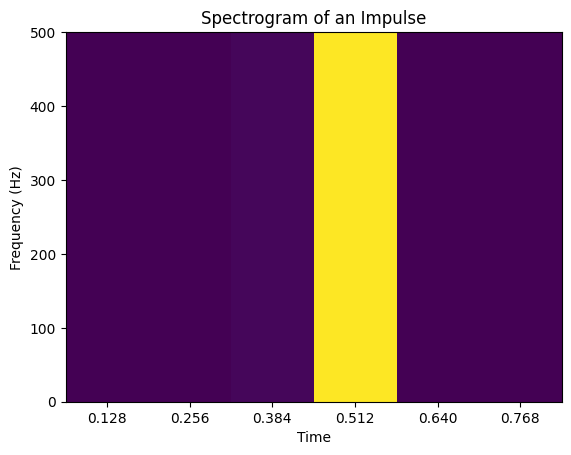

In [15]:
impulse = sp.signal.unit_impulse(len(time), round(len(time)/2))
s, s_freq, s_t, im = plt.specgram(impulse, NFFT=256, Fs = N, interpolation='none', scale='linear', mode='magnitude') 
plt.title("Spectrogram of an Impulse")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.xticks(s_t)

We see that the spectrogram is positive only at the timestamp of the impulse and exhibits all frequencies.

### Orca Call Spectrogram

Let's look at one real example: a call of an Orca from the [Watkins Marine Mammal Sound Database](https://whoicf2.whoi.edu/science/B/whalesounds/).

In [16]:
import IPython
IPython.display.Audio("https://whoicf2.whoi.edu/science/B/whalesounds/WhaleSounds/92301007.wav")

In [17]:
from scipy.io import wavfile

In [18]:
!wget -q --no-check-certificate 'https://whoicf2.whoi.edu/science/B/whalesounds/WhaleSounds/92301007.wav' -O Orca_call.wav

In [19]:
# reading a buzz call
samplerate, signal = wavfile.read('Orca_call.wav')

In [20]:
N = len(signal)

Text(0, 0.5, 'Frequency (Hz)')

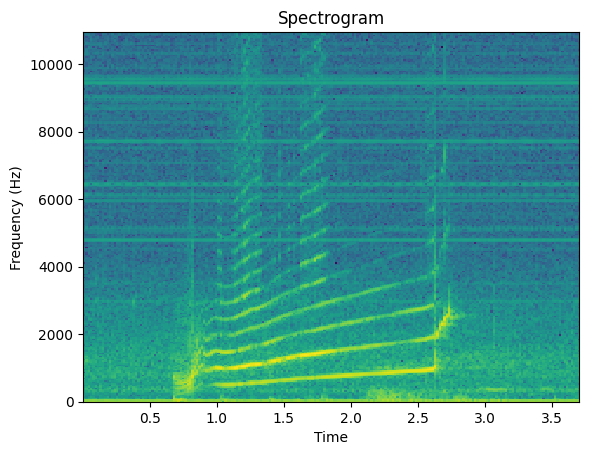

In [21]:
s, s_freq, s_t, im = plt.specgram(signal, NFFT=512, Fs = samplerate, interpolation='none')
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")


In [22]:
def plot_stft_slice(t, NFFT=256, noverlap=128):

    fig, ax = plt.subplots(2,2)
    fig.set_figheight(6)
    fig.set_figwidth(10)


    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()

    # identify time window based on t and NFFT
    win_length = NFFT/N

    # plot raw signal with window
    ax[0,0].plot(np.linspace(0,len(signal)/samplerate, len(signal)), signal)

    # plot spectrogram with a verical line
    s, s_freq, s_t, im = ax[1,0].specgram(signal, NFFT=NFFT, noverlap=noverlap, Fs = samplerate, interpolation='none')
    ax[0,0].axvline(t-win_length/2, color="r")
    ax[0,0].axvline(t+win_length/2, color="r")
    ax[0,0].axvspan(t-win_length/2, t+win_length/2, color='red', alpha=.5)
    #ax[0,0].set_ylim((-2,2))
    ax[0,0].set_xlim((0, N/samplerate))
    ax[0,0].set_title("Signal")


    idx = np.where(s_t == t)[0]
    ax[1,0].axvline(t, color='r')
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Frequency")
    ax[1,0].set_title("STFT")
    ax[1,0].set_xlim((0, N/samplerate))
    # ax[1,0].set_xticks(np.concat(([0], s_t, [N/samplerate])))

    # plot power spectrum of slice
    ax[1,1].plot(s[:,idx]/s.max(), s_freq)
    ax[1,1].set_xlabel("normalized |FFT|")
    ax[1,1].set_title("|FFT|")
    ax[1,1].set_xlim((-0.001, 1))

    # making one axis invisible
    ax[0,1].axis('off')
    plt.show()

In [23]:
NFFT_widget = widgets.SelectionSlider(options=[256, 512, 1024, 2048])
NFFT_widget.value = 256
noverlap_widget = widgets.SelectionSlider(options=[0,32,64,128])
noverlap_widget.value = 128

time_widget = widgets.SelectionSlider(options=np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N*N/samplerate)


# Update function
def update_time_slider(change):
    time_widget.options = np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N*N/samplerate

NFFT_widget.observe(update_time_slider, names='value')
noverlap_widget.observe(update_time_slider, names='value')


out = interactive(plot_stft_slice, NFFT=NFFT_widget, noverlap=noverlap_widget, t=time_widget)
display(out)

interactive(children=(SelectionSlider(description='t', options=(np.float64(0.005844748858447488), np.float64(0…

Explore how the spectrum changes with time and how the NFFT affects the resolution.